In [1]:
# Import usefull libraries
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib
import scipy.io
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from astropy.io import fits
from scipy.io import savemat
import tensorly as tl
import mu_ntd.algorithms.Sparse_ntd as SNTD
import mu_ntd.algorithms.VCA as vca
from nn_fac import ntd as NTD

In [2]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [39]:
# Load data set - HSI Samson
mat = scipy.io.loadmat('../Data/JasperRidge/jasperRidge2_R198.mat')
A=mat['Y']
A = A/np.amax(A)
res1_array = mat['nCol']
res1 = res1_array[0][0]
res2_array = mat['nRow']
res2 = res2_array[0][0]
res3_array = mat['nBand']
res3 = 198
# Estimate endmembers with Vertex Component Analysis
Ae, indice, Yp = vca.vca(A,R=4,verbose = True, snr_input = 20)

input SNR = 20[dB]

... Select proj. to R-1


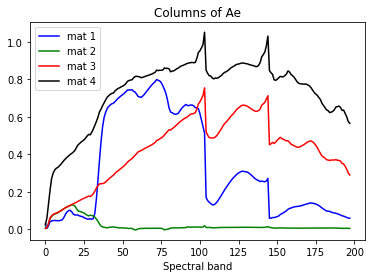

In [40]:
plt.figure(1)
plt.plot(Ae[:,0], color='blue', label='mat 1')
plt.plot(Ae[:,1], color='green', label='mat 2')
plt.plot(Ae[:,2], color='red', label='mat 3')
plt.plot(Ae[:,3], color='black', label='mat 4')
plt.xlabel('Spectral band')
#plt.ylabel('Objective function')
plt.title('Columns of Ae')
plt.legend()
plt.show()

In [5]:
#  Reshape from matrix to tensor
T = np.reshape(A.T, (res1, res2, res3))
T = T/np.amax(T)
Ae.shape
#T = np.maximum(T, 1e-12)

(198, 4)

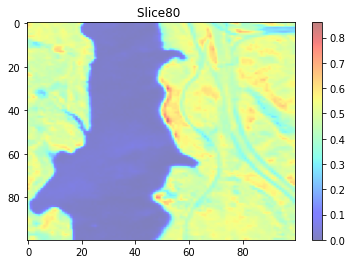

In [6]:
# Visualization of input tensor T
light_jet = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.jet)
nSlice = 80
counter_fig = 1
pl.figure(counter_fig)
pl.imshow(T[:,:,nSlice].T, cmap=light_jet, aspect='auto')
pl.title("Slice%1.0f" %nSlice+ " ")
pl.colorbar()
pl.show()
counter_fig = counter_fig + 1

In [7]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Initialization
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
U_lines = res1
V_lines = res2
W_lines = res3
ranks = [80,80,4]

In [8]:
# Random initialization for the NTD
factors_init = []
factors_init.append(np.random.rand(U_lines, ranks[0]))
factors_init.append(np.random.rand(V_lines, ranks[1]))
#factors_init.append(np.random.rand(W_lines, ranks[2]))
factors_init.append(Ae)
core_init = np.random.rand(ranks[0], ranks[1], ranks[2])

In [41]:
# Solver parameters
n_iter_max = 3000
beta = 1
iter_inner = 2
tol = 0 #running all iterations
l2weight = np.array([0, 4, 1, 3/2])  #(\mu_g, \mu_W, \mu_H, \mu_Q)
l1weight = np.array([3/4, 0, 0, 0])  #(\mu_g, \mu_W, \mu_H, \mu_Q)

In [42]:
#------------------------------
# Call of solvers
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ### Beta = 1 - MU no extrapolation
core, factors, cost_fct_vals, toc, alpha = SNTD.sntd_mu(T, ranks, l2weights=l2weight, l1weights=l1weight, init = "custom", core_0 = core_init, factors_0 = factors_init, n_iter_max = n_iter_max, tol=tol, beta = beta,
                                                fixed_modes = [], normalize = 4*[None], verbose = False, return_costs = True, extrapolate=False, iter_inner=iter_inner)

100%|██████████| 3000/3000 [12:58<00:00,  3.85it/s]


In [43]:
# ### Beta = 1 - MU extrapolation
core_HER, factors_HER, cost_fct_vals_HER, toc_HER, alpha_HER = SNTD.sntd_mu(T, ranks, l2weights=l2weight, l1weights=l1weight, init = "custom", core_0 = core_init, factors_0 = factors_init, n_iter_max = n_iter_max, tol=tol, beta = beta,
                                                fixed_modes = [], normalize = 4*[None], verbose = False, return_costs = True, extrapolate=True, iter_inner=iter_inner)

100%|██████████| 3000/3000 [12:56<00:00,  3.86it/s]


In [77]:
# ### HALS as in nn_fac
core_HALS, factors_HALS, cost_fct_vals_HALS, toc_HALS = NTD.ntd(T, ranks, init = "custom", core_0 = np.copy(core_init), factors_0 = np.copy(factors_init), n_iter_max = n_iter_max, tol = 1e-6,
                                                sparsity_coefficients = [1/5, 1/5, 1/5, 1/5], fixed_modes = [], normalize = None, verbose = False, return_costs = True, accelerate=False)

C:\Users\valen\anaconda3\lib\site-packages\numpy\lib\function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Irrelevant number of normalization booleans (different from the number of modes + 1 for the core), they have been set to False.


In [78]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Reporting
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("-----------------------------------------------------------------------")
print("Reporting results:")
print("-----------------------------------------------------------------------")
print("Final loss function value:")
print(f"MU, Beta = {beta}       : {cost_fct_vals[-1]}, converged in {len(cost_fct_vals) - 1} iterations.")
print(f"MU - HER, Beta = {beta} : {cost_fct_vals_HER[-1]}, converged in {len(cost_fct_vals_HER) - 1} iterations.")
print(f"HALS               : {cost_fct_vals_HALS[-1]}, converged in {len(cost_fct_vals_HALS) - 1} iterations.")
print("-----------------------------------------------------------------------")
print("Final relative construction error:")
print(f"MU, Beta = {beta}       : {tl.norm(T-tl.tenalg.multi_mode_dot(core, factors))/tl.norm(T)*100} %")
print(f"MU - HER, Beta = {beta} : {tl.norm(T-tl.tenalg.multi_mode_dot(core_HER, factors_HER))/tl.norm(T)*100} %")
print(f"HALS               : {tl.norm(T-tl.tenalg.multi_mode_dot(core_HALS, factors_HALS))/tl.norm(T)*100} %")

-----------------------------------------------------------------------
Reporting results:
-----------------------------------------------------------------------
Final loss function value:
MU, Beta = 1       : 2182.677450128008, converged in 3000 iterations.
MU - HER, Beta = 1 : 2557.7497457312047, converged in 3000 iterations.
HALS               : 526.1745451132153, converged in 3000 iterations.
-----------------------------------------------------------------------
Final relative construction error:
MU, Beta = 1       : 6.213210538516431 %
MU - HER, Beta = 1 : 7.431365019779319 %
HALS               : 5.342350328092853 %


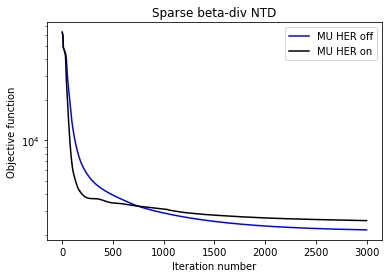

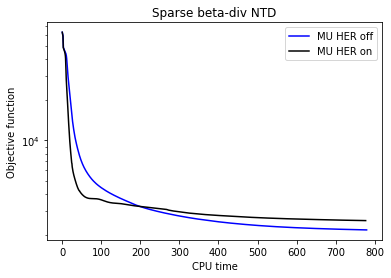

In [46]:
# first iteration shown?
it1 = 1

plt.figure(1)
plt.semilogy(cost_fct_vals[it1:], color='blue', label='MU HER off')
plt.semilogy(cost_fct_vals_HER[it1:], color='black', label='MU HER on')
plt.xlabel('Iteration number')
plt.ylabel('Objective function')
plt.title('Sparse beta-div NTD')
plt.legend()
plt.show()

plt.figure(2)
plt.semilogy(toc[it1:],cost_fct_vals[it1:], color='blue', label='MU HER off')
plt.semilogy(toc_HER[it1:],cost_fct_vals_HER[it1:], color='black', label='MU HER on')
plt.xlabel('CPU time')
plt.ylabel('Objective function')
plt.title('Sparse beta-div NTD')
plt.legend()
plt.show()

In [47]:
# norm for factors 1
if not l2weight[1]:
    print(tl.norm(factors[0],1))
else:
    print(tl.norm(factors[0],2)**2)

51.82880165384404


In [48]:
# norm for factors 2
if not l2weight[2]:
    print(tl.norm(factors[1],1))
else:
    print(tl.norm(factors[1],2)**2)

158.64616410881635


In [49]:
# norm for factors 3
if not l2weight[3]:
    print(tl.norm(factors[2],1))
else:
    print(tl.norm(factors[2],2)**2)

121.06759577340847


In [50]:
# norm for core tensor
if not l2weight[0]:
    print(tl.norm(core,1))
else:
    print(tl.norm(core,2)**2)

392.7367190814444


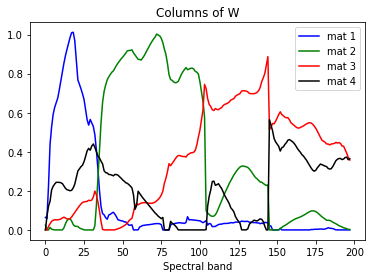

In [51]:
U = factors[0]
V = factors[1]
W = factors[2]
plt.figure(1)
plt.plot(W[:,0], color='blue', label='mat 1')
plt.plot(W[:,1], color='green', label='mat 2')
plt.plot(W[:,2], color='red', label='mat 3')
plt.plot(W[:,3], color='black', label='mat 4')
plt.xlabel('Spectral band')
#plt.ylabel('Objective function')
plt.title('Columns of W')
plt.legend()
plt.show()

In [52]:
mode = 2
A = tl.unfold(tl.tenalg.multi_mode_dot(core, factors, skip = mode), mode)

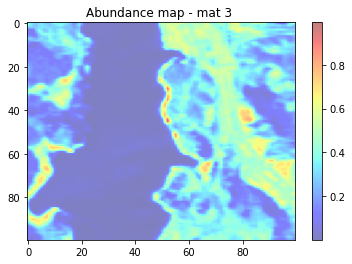

In [74]:
nMat = 2
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
pl.figure(counter_fig)
pl.imshow(A1.T, cmap=light_jet, aspect='auto')
pl.title("Abundance map - mat %1.0f" %nMat_graph + " ")
pl.colorbar()
pl.show()

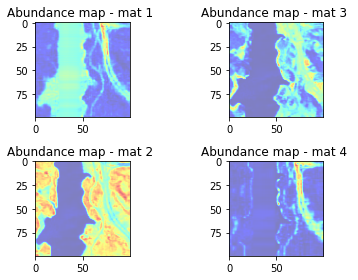

In [54]:
fig, axs = pl.subplots(2, 2)
nMat = 0
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[0, 0].imshow(A1.T, cmap=light_jet, aspect='auto')
axs[0, 0].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[0, 0].set_aspect('equal', 'box')
nMat = 1
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[1, 0].imshow(A1.T, cmap=light_jet, aspect='auto')
axs[1, 0].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[1, 0].set_aspect('equal', 'box')
nMat = 2
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].imshow(A1.T, cmap=light_jet, aspect='auto')
axs[0, 1].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[0, 1].set_aspect('equal', 'box')
nMat = 3
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[1, 1].imshow(A1.T, cmap=light_jet, aspect='auto')
axs[1, 1].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[1, 1].set_aspect('equal', 'box')
#pl.colorbar()
fig.tight_layout()

In [64]:
# Number of variables for equivalent NMF m
(res1**2)*ranks[2]+ranks[2]*res3

40792

In [65]:
# Number of variables for equivalent NMF model:
res1*ranks[0]+res2*ranks[1]+ranks[2]*res3+ranks[0]*ranks[1]*ranks[2]

42392

In [66]:
# Ratio penalty functions w.r.t. total objective function in %, l1 reg Core and L2 reg for factors
(l1weight[0]*tl.norm(core,1)+l1weight[1]*tl.norm(factors[0],1) + l1weight[2]*tl.norm(factors[1],1) + l1weight[3]*tl.norm(factors[2],1))/cost_fct_vals[-1]*100

13.495009960991197

In [67]:
# Ratio penalty functions w.r.t. total objective function in %, l1 reg Core and L2 reg for factors
(l1weight[0]*tl.norm(core,1)+l2weight[1]*tl.norm(factors[0],2)**2 + l2weight[2]*tl.norm(factors[1],2)**2 + l2weight[3]*tl.norm(factors[2],2)**2)/cost_fct_vals[-1]*100

38.58175671563386

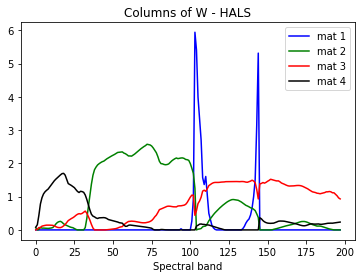

In [79]:
# Plot HALS for comparison
U_HALS = factors_HALS[0]
V_HALS = factors_HALS[1]
W_HALS = factors_HALS[2]
plt.figure(1)
plt.plot(W_HALS[:,0], color='blue', label='mat 1')
plt.plot(W_HALS[:,1], color='green', label='mat 2')
plt.plot(W_HALS[:,2], color='red', label='mat 3')
plt.plot(W_HALS[:,3], color='black', label='mat 4')
plt.xlabel('Spectral band')
#plt.ylabel('Objective function')
plt.title('Columns of W - HALS')
plt.legend()
plt.show()

In [80]:
mode = 2
A_HALS = tl.unfold(tl.tenalg.multi_mode_dot(core_HALS, factors_HALS, skip = mode), mode)

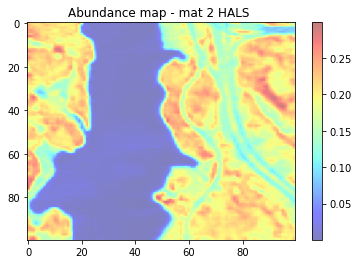

In [81]:
nMat = 1
A1_HALS = np.reshape(A_HALS[nMat,:],(res1, res2))
nMat_graph = nMat + 1
pl.figure(counter_fig)
pl.imshow(A1_HALS.T, cmap=light_jet, aspect='auto')
pl.title("Abundance map - mat %1.0f" %nMat_graph + " HALS ")
pl.colorbar()
pl.show()

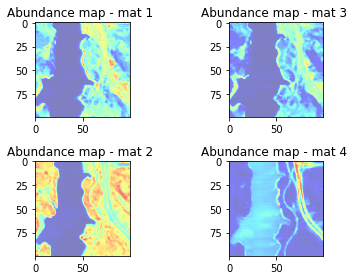

In [82]:
fig, axs = pl.subplots(2, 2)
nMat = 0
A1_HALS = np.reshape(A_HALS[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[0, 0].imshow(A1_HALS.T, cmap=light_jet, aspect='auto')
axs[0, 0].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[0, 0].set_aspect('equal', 'box')
nMat = 1
A1_HALS = np.reshape(A_HALS[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[1, 0].imshow(A1_HALS.T, cmap=light_jet, aspect='auto')
axs[1, 0].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[1, 0].set_aspect('equal', 'box')
nMat = 2
A1_HALS = np.reshape(A_HALS[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].imshow(A1_HALS.T, cmap=light_jet, aspect='auto')
axs[0, 1].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[0, 1].set_aspect('equal', 'box')
nMat = 3
A1_HALS = np.reshape(A_HALS[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[1, 1].imshow(A1_HALS.T, cmap=light_jet, aspect='auto')
axs[1, 1].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[1, 1].set_aspect('equal', 'box')
#pl.colorbar()
fig.tight_layout()

In [83]:
# Ratio penalty functions w.r.t. total objective function in %, l1 reg Core and L2 reg for factors
(1/5*tl.norm(core_HALS,1)+1/4*tl.norm(factors_HALS[0],1) + 1/4*tl.norm(factors_HALS[1],1) + 1/5*tl.norm(factors_HALS[2],1))/cost_fct_vals_HALS[-1]*100

54.27635933408589